- 0001078580 Gianluca Di Mauro  -> gianluca.dimauro@studio.unibo.it
- 0001057801 Leonardo Monti -> leonardo.monti3@studio.unibo.it

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
"""%pip install google-colab

from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip"""

"%pip install google-colab\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./\n!unzip dataset.zip"

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

# TRACK A 

In [2]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Image Preprocessing
The first step in our detection pipeline involves preprocessing the input scene images to reduce noise and improve feature detection quality.
Robust feature detection requires clean input images. Raw scene images often contain various types of noise that can interfere with feature detection and matching:

- Salt-and-pepper noise can create false feature points
- General image noise can affect the stability of feature descriptors
- Edge artifacts can lead to false feature matches

We implement a two-stage filtering approach:
1. Median blur eliminates salt-and-pepper noise while preserving strong edges, unlike Gaussian blur which can blur important details
2. Bilateral filtering provides edge-aware smoothing, reducing noise in uniform regions while maintaining sharp edges crucial for feature detection

This preprocessing pipeline significantly improves the reliability of subsequent SIFT feature detection and matching.

In [3]:
def preprocess_scene(img):
    """
    Preprocess an input scene image to reduce noise and improve feature detection.

    Parameters:
        img (numpy.ndarray): Input image in BGR format

    Returns:
        numpy.ndarray: Preprocessed image

    Actions:
        1. Applies median blur with 9x9 kernel to remove salt-and-pepper noise
        2. Applies bilateral filter to reduce noise while preserving edges
           - sigmaColor=25: Controls how much colors within a neighborhood will be mixed together
           - sigmaSpace=15: Controls the spatial extent of the kernel
    """

    img = cv2.medianBlur(img, 9)
    img = cv2.bilateralFilter(img, d=-1, sigmaColor=25, sigmaSpace=15)
    return img

## Geometric Operations
Geometric analysis is crucial for validating potential matches and determining precise object locations. We implement several geometric utility functions that work together to provide robust spatial analysis:

1. Center Computation:
   - Essential for determining object position
   - Uses average of corner coordinates instead of bounding box center
   - More robust to perspective distortion than simple bbox center
   
2. Bounding Box Analysis:
   - Provides critical measurements for validation
   - Handles cases where perspective distortion affects apparent size
   - Enables consistent size-based filtering across different viewing angles

These geometric operations form the foundation for more complex validation steps later in the pipeline.

In [4]:
def compute_center(corners):
    """
    Calculate the center point of a set of corners.

    Parameters:
        corners (numpy.ndarray): Array of corner points in format Nx1x2

    Returns:
        tuple: (x, y) coordinates of the center point

    Actions:
        Computes mean of x and y coordinates separately to find centroid
    """
    x_coords = [c[0][0] for c in corners]
    y_coords = [c[0][1] for c in corners]
    return (np.mean(x_coords), np.mean(y_coords))


def bounding_box_dims(corners):
    """
    Calculate the width and height of a bounding box defined by corners.

    Parameters:
        corners (numpy.ndarray): Array of corner points in format Nx1x2

    Returns:
        tuple: (width, height) of the bounding box

    Actions:
        1. Extracts x and y coordinates from corners
        2. Calculates width as max_x - min_x
        3. Calculates height as max_y - min_y
    """
    x_coords = [c[0][0] for c in corners]
    y_coords = [c[0][1] for c in corners]
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)
    return width, height

## Validation Functions
Multiple validation layers are crucial for robust object detection. Each validation step addresses specific types of false positives that can occur in real-world scenarios:

### Aspect Ratio Validation
Object appearance can vary due to perspective, but certain geometric properties should remain relatively stable:
- Aspect ratio is particularly important as it's partially invariant to perspective
- We allow for some deviation (controlled by tolerance parameter) to account for perspective effects
- This check effectively filters out many geometrically implausible detections

### Color Verification
SIFT features are geometry-based and don't consider appearance. We add color validation because:
- Similar shapes might have completely different colors
- Color comparison in Lab space is more perceptually accurate than RGB
- Mean color difference provides a quick but effective check for gross color mismatches
- The transformation to Lab space helps handle illumination variations

### Overlap Prevention (IOU-Based)
Multiple detections of the same object instance can occur because:
- Features can be detected at different scales
- Similar patterns might exist in close proximity
- Perspective variations can lead to multiple valid homographies

Our IOU-based approach:
- Calculates actual overlap between detections
- Uses a configurable threshold to determine acceptable overlap
- More accurate than simple center-distance checks
- Effectively prevents double-counting while allowing legitimate close instances

In [5]:
def check_aspect_ratio(width, height, ref_width, ref_height, tolerance=0.3):
    """
    Verify if detected object's aspect ratio matches the reference within tolerance.

    Parameters:
        width (float): Width of detected object
        height (float): Height of detected object
        ref_width (float): Width of reference object
        ref_height (float): Height of reference object
        tolerance (float): Maximum allowed deviation from reference aspect ratio

    Returns:
        bool: True if aspect ratio is within tolerance, False otherwise

    Actions:
        1. Calculates aspect ratios for reference and detected objects
        2. Compares ratios using relative difference
    """
    ref_ratio = ref_width / float(ref_height + 1e-6)
    det_ratio = width / float(height + 1e-6)
    return (abs(det_ratio - ref_ratio) / ref_ratio) < tolerance


def simple_color_check(scene_img, corners, ref_img):
    """
    Verify color similarity between detected object and reference image.

    Parameters:
        scene_img (numpy.ndarray): Full scene image
        corners (numpy.ndarray): Corners of detected object
        ref_img (numpy.ndarray): Reference product image

    Returns:
        bool: True if colors are similar enough, False otherwise

    Actions:
        1. Performs perspective transform to align detected region with reference
        2. Converts both images to Lab color space
        3. Computes mean color difference in Lab space
        4. Returns True if difference is below threshold
    """
    h, w = ref_img.shape[:2]
    src_points = np.float32(
        [corners[0][0], corners[1][0], corners[2][0], corners[3][0]]
    )
    dst_points = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(scene_img, M, (w, h))

    # Convert both to Lab and compute mean difference
    ref_lab = cv2.cvtColor(ref_img, cv2.COLOR_BGR2Lab)
    warped_lab = cv2.cvtColor(warped, cv2.COLOR_BGR2Lab)

    ref_mean = np.mean(ref_lab.reshape(-1, 3), axis=0)
    warped_mean = np.mean(warped_lab.reshape(-1, 3), axis=0)
    diff = np.linalg.norm(ref_mean - warped_mean)

    # Threshold can be tuned; smaller is stricter (color must be similar)
    return diff < 25.0


def iou_check(new_box, existing_boxes, threshold=0.3):
    """
    Check if a new detection overlaps too much with existing detections.

    Parameters:
        new_box (numpy.ndarray): Corners of new detection
        existing_boxes (list): List of corners for previous detections
        threshold (float): Maximum allowed IOU value

    Returns:
        bool: True if overlap is too high, False otherwise

    Actions:
        1. Converts corner format to x,y,w,h format
        2. Calculates Intersection over Union with each existing detection
        3. Returns True if any IOU exceeds threshold
    """

    def box_to_xywh(box):
        xs = [p[0][0] for p in box]
        ys = [p[0][1] for p in box]
        x_min, x_max = min(xs), max(xs)
        y_min, y_max = min(ys), max(ys)
        return x_min, y_min, (x_max - x_min), (y_max - y_min)

    x1, y1, w1, h1 = box_to_xywh(new_box)
    for eb in existing_boxes:
        x2, y2, w2, h2 = box_to_xywh(eb)
        inter_x1 = max(x1, x2)
        inter_y1 = max(y1, y2)
        inter_x2 = min(x1 + w1, x2 + w2)
        inter_y2 = min(y1 + h1, y2 + h2)

        inter_w = max(0, inter_x2 - inter_x1)
        inter_h = max(0, inter_y2 - inter_y1)
        inter_area = inter_w * inter_h
        area1 = w1 * h1
        area2 = w2 * h2
        iou = inter_area / float(area1 + area2 - inter_area + 1e-6)
        if iou > threshold:
            return True
    return False

## Core Detection System
The main detection pipeline implements a sophisticated SIFT-based approach with multiple enhancements:

1. Feature Detection:
   - Uses SIFT due to its scale and rotation invariance
   - Parameters tuned for optimal performance:
     * High feature count to handle partial occlusions
     * Lower contrast threshold to detect subtle features
     * Modified edge threshold for better stability

2. Feature Matching:
   - FLANN-based matching for efficiency
   - Strict ratio test to ensure match quality
   - Multiple validation layers to eliminate false positives

3. Instance Detection:
   - Iterative detection process to find multiple instances
   - Mask-based approach to prevent re-detection
   - Comprehensive validation pipeline

In [6]:
def detect_instances_for_product(model_img, scene_img, product_id, existing_boxes):
    """
    Detect multiple instances of a single product in a scene using SIFT features.

    Parameters:
        model_img (numpy.ndarray): Reference product image
        scene_img (numpy.ndarray): Scene image to search in
        product_id (str): Identifier for the product
        existing_boxes (list): List of previously detected boxes

    Returns:
        list: List of dictionaries containing detection information
              Each dict contains: model_name, corners, width, height, position

    Actions:
        1. Initializes SIFT detector with optimized parameters
        2. Converts images to grayscale and extracts SIFT features
        3. Iteratively attempts to find product instances:
           - Performs feature matching using FLANN
           - Computes homography using RANSAC
           - Validates detection using multiple checks:
             * Minimum size check
             * Aspect ratio check
             * Color similarity check
             * Overlap with existing detections check
        4. Masks found instances to avoid re-detection
        5. Continues until no more valid instances are found or max attempts reached
    """
    # Parameter tuning for SIFT
    sift = cv2.SIFT_create(
        nfeatures=20000,
        nOctaveLayers=6,
        contrastThreshold=0.005,  # Slightly lower
        edgeThreshold=13,  # Slightly lower
    )
    model_gray = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)
    scene_gray = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)

    kp_model, des_model = sift.detectAndCompute(model_gray, None)
    if des_model is None:
        return []

    detections = []
    mask = np.zeros(scene_gray.shape, dtype=np.uint8)  # Mask for found instances
    attempts = 0
    max_attempts = 10

    ref_h, ref_w = model_img.shape[:2]

    while attempts < max_attempts:
        attempts += 1
        # Apply mask to avoid redetecting the same instance
        masked_scene = cv2.bitwise_and(
            scene_gray, scene_gray, mask=cv2.bitwise_not(mask)
        )
        kp_scene, des_scene = sift.detectAndCompute(masked_scene, None)
        if des_scene is None or len(kp_scene) < 10:
            break

        # FLANN matching
        flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=3), dict(checks=300))
        matches = flann.knnMatch(des_model, des_scene, k=2)
        good = []
        ratio_thresh = 0.7  # stricter ratio test
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good.append(m)

        # Require at least 15 matches
        if len(good) < 15:
            break

        src_pts = np.float32([kp_model[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        H, inliers = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)
        if H is None:
            continue

        corners = np.float32(
            [[0, 0], [0, ref_h - 1], [ref_w - 1, ref_h - 1], [ref_w - 1, 0]]
        ).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, H)

        # Compute width/height of detected instance
        width, height = bounding_box_dims(transformed_corners)

        # Basic sanity checks
        if (
            width < 30
            or height < 30
            or width * height > scene_img.shape[0] * scene_img.shape[1] * 0.8
        ):
            continue

        # Check aspect ratio
        if not check_aspect_ratio(width, height, ref_w, ref_h, tolerance=0.3):
            continue

        # Simple color check
        if not simple_color_check(scene_img, transformed_corners, model_img):
            continue

        # IOU check with existing detections
        if iou_check(transformed_corners, existing_boxes):
            continue

        # Calculate confidence based on inlier ratio
        num_inliers = np.sum(inliers)
        confidence = float(num_inliers) / len(good)

        # Passed all checks, add detection
        detections.append(
            {
                "model_name": product_id,
                "corners": transformed_corners,
                "width": int(width),
                "height": int(height),
                "position": (
                    int(np.mean(transformed_corners[:, 0, 0])),
                    int(np.mean(transformed_corners[:, 0, 1])),
                ),
                "confidence": confidence,
            }
        )

        existing_boxes.append(transformed_corners)
        cv2.fillPoly(mask, [np.int32(transformed_corners)], 255)

    return detections

## Main Processing Pipeline
Functions that orchestrates the overall detection process

In [7]:
def detect_products(models_path, scenes_path):
    """
    Main function to process all scenes and detect all product instances.

    Parameters:
        models_path (str): Path to directory containing reference product images
        scenes_path (str): Path to directory containing scene images

    Returns:
        dict: Nested dictionary containing all detections for each scene

    Actions:
        1. Loads all model and scene images
        2. Preprocesses scene images
        3. For each scene:
           - Attempts to detect each product
           - Maintains list of all detections
        4. Returns structured results
    """
    models = {}
    for img_path in sorted(
        Path(models_path).glob("*.png"), key=lambda x: int(x.stem.replace("ref", ""))
    ):
        models[img_path.stem] = cv2.imread(str(img_path))

    # Load scenes
    scenes = {}
    for img_path in sorted(
        Path(scenes_path).glob("*.png"), key=lambda x: int(x.stem.replace("scene", ""))
    ):
        scene = cv2.imread(str(img_path))
        scene = preprocess_scene(scene)
        scenes[img_path.stem] = scene

    results = {}
    for scene_name, scene_img in scenes.items():
        print(f"\nProcessing {scene_name}...")
        all_detections = {}
        existing_boxes = []

        for product_id, model_img in models.items():
            product_detections = detect_instances_for_product(
                model_img, scene_img, product_id, existing_boxes
            )
            if len(product_detections) > 0:
                all_detections[product_id] = product_detections

        results[scene_name] = all_detections
        print(f"Completed {scene_name}. Found:")
        for p_id, dets in all_detections.items():
            print(f"  {p_id}: {len(dets)} instance(s)")

    return results

## Visualization System
Effective visualization is crucial for both development and end-user understanding:

1. Individual Detection Visualization:
   - Green polygons clearly outline detected objects
   - Center points provide reference for position tracking
   - Text labels identify specific products
   - Color coding helps distinguish between different confidence levels

2. Complete Results Display:
   - Comprehensive view of all detections in each scene
   - Statistical summaries for quick analysis
   - Clear presentation of detection metrics
   - Easy-to-interpret visual format

The visualization system serves both debugging and presentation purposes, making it easier to verify and communicate results.

In [ ]:
def visualize_detection(scene_img, detection):
    """
    Draw a single detection on an image.

    Parameters:
        scene_img (numpy.ndarray): Image to draw on
        detection (dict): Detection information including corners and product name

    Returns:
        numpy.ndarray: Image with detection visualization

    Actions:
        1. Draws colored polygon around detected object, color based on confidece
        2. Draws blue center point
        3. Adds product name label
    """

    # Color-coded confidence
    confidence = detection["confidence"]
    color = (
        int(255 * (1 - confidence)),  # Red increases with low confidence
        int(255 * confidence),  # Green increases with high confidence
        0,
    )

    img = scene_img.copy()
    corners = np.int32(detection["corners"])
    cv2.polylines(img, [corners], True, color, 3)
    cv2.circle(img, detection["position"], 5, (255, 0, 0), -1)
    text = f"{detection['model_name']}"
    cv2.putText(
        img,
        text,
        (detection["position"][0], detection["position"][1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
    )
    return img


def plot_results(results, scenes_path):
    """
    Visualize and display all detection results.

    Parameters:
        results (dict): Detection results from detect_products()
        scenes_path (str): Path to scene images

    Returns:
        None

    Actions:
        1. For each scene:
           - Loads original image
           - Visualizes all detections
           - Displays using matplotlib
           - Prints detection statistics
    """
    for scene_name, detections in results.items():
        scene_img = cv2.imread(f"{scenes_path}/{scene_name}.png")
        img = scene_img.copy()
        for product_name, dets in detections.items():
            for det in dets:
                img = visualize_detection(img, det)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(
            figsize=(15, 10), dpi=40
        )  # dpi reduced from 100 to 40 because the max submission size is only 20MB!
        plt.imshow(img_rgb)
        plt.title(f"Results for {scene_name}")
        plt.axis("off")
        plt.show()

        # Print details
        print(f"\nResults for {scene_name}:")
        for product_name, dets in detections.items():
            print(f"Product {product_name} - {len(dets)} instance(s) found:")
            for i, det in enumerate(dets, start=1):
                print(
                    f"  Instance {i} {{position: {det['position']}, width: {det['width']}px, height: {det['height']}px}}"
                )

## Track A


Processing scene1...
Completed scene1. Found:
  ref1: 2 instance(s)

Processing scene2...
Completed scene2. Found:
  ref3: 1 instance(s)
  ref4: 1 instance(s)
  ref5: 1 instance(s)

Processing scene3...
Completed scene3. Found:
  ref3: 1 instance(s)
  ref6: 1 instance(s)
  ref7: 1 instance(s)

Processing scene4...
Completed scene4. Found:
  ref1: 2 instance(s)
  ref8: 1 instance(s)
  ref9: 1 instance(s)

Processing scene5...
Completed scene5. Found:
  ref11: 1 instance(s)


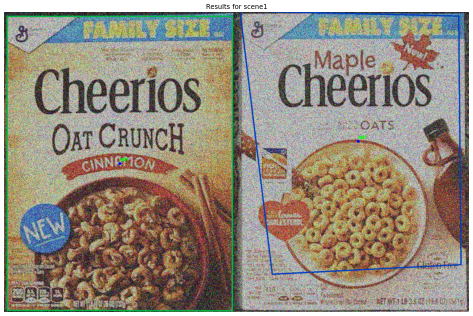


Results for scene1:
Product ref1 - 2 instance(s) found:
  Instance 1 {position: (412, 539), width: 802px, height: 1048px}
  Instance 2 {position: (1261, 460), width: 786px, height: 937px}


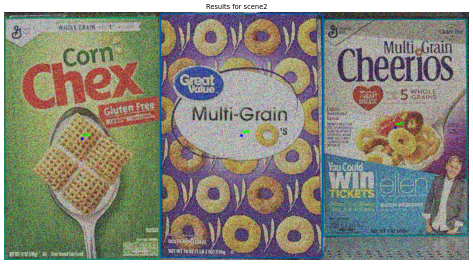


Results for scene2:
Product ref3 - 1 instance(s) found:
  Instance 1 {position: (305, 494), width: 604px, height: 941px}
Product ref4 - 1 instance(s) found:
  Instance 1 {position: (927, 482), width: 633px, height: 951px}
Product ref5 - 1 instance(s) found:
  Instance 1 {position: (1528, 451), width: 561px, height: 845px}


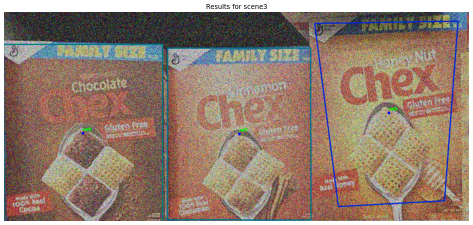


Results for scene3:
Product ref3 - 1 instance(s) found:
  Instance 1 {position: (1455, 381), width: 541px, height: 700px}
Product ref6 - 1 instance(s) found:
  Instance 1 {position: (298, 458), width: 601px, height: 672px}
Product ref7 - 1 instance(s) found:
  Instance 1 {position: (889, 461), width: 543px, height: 650px}


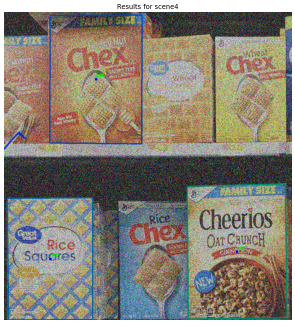


Results for scene4:
Product ref1 - 2 instance(s) found:
  Instance 1 {position: (886, 913), width: 380px, height: 514px}
  Instance 2 {position: (-30, 569), width: 394px, height: 417px}
Product ref8 - 1 instance(s) found:
  Instance 1 {position: (350, 256), width: 350px, height: 491px}
Product ref9 - 1 instance(s) found:
  Instance 1 {position: (176, 941), width: 325px, height: 465px}


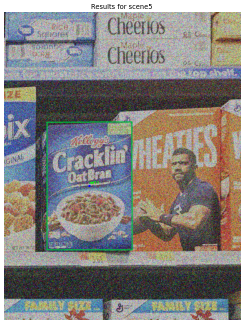


Results for scene5:
Product ref11 - 1 instance(s) found:
  Instance 1 {position: (368, 752), width: 367px, height: 552px}


In [9]:
dataset_path = "./dataset/Track A"
results = detect_products(dataset_path + "/models", dataset_path + "/scenes")
plot_results(results, dataset_path + "/scenes")

## Track B


Processing scene6...
Completed scene6. Found:
  ref15: 4 instance(s)

Processing scene7...
Completed scene7. Found:
  ref16: 2 instance(s)

Processing scene8...
Completed scene8. Found:
  ref17: 3 instance(s)

Processing scene9...
Completed scene9. Found:
  ref19: 1 instance(s)
  ref20: 2 instance(s)

Processing scene10...
Completed scene10. Found:

Processing scene11...
Completed scene11. Found:
  ref17: 4 instance(s)
  ref25: 3 instance(s)

Processing scene12...
Completed scene12. Found:
  ref26: 4 instance(s)


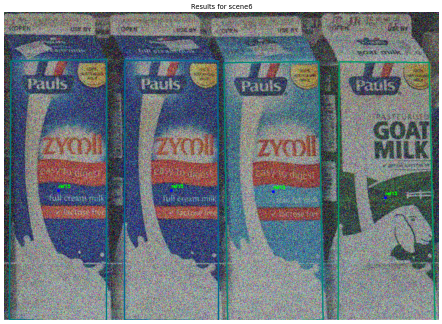


Results for scene6:
Product ref15 - 4 instance(s) found:
  Instance 1 {position: (582, 621), width: 326px, height: 906px}
  Instance 2 {position: (189, 621), width: 339px, height: 915px}
  Instance 3 {position: (937, 625), width: 344px, height: 907px}
  Instance 4 {position: (1327, 646), width: 337px, height: 974px}


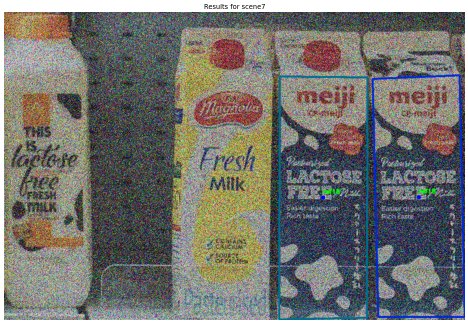


Results for scene7:
Product ref16 - 2 instance(s) found:
  Instance 1 {position: (1031, 460), width: 229px, height: 601px}
  Instance 2 {position: (793, 461), width: 218px, height: 604px}


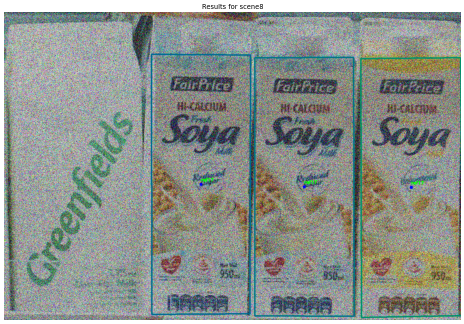


Results for scene8:
Product ref17 - 3 instance(s) found:
  Instance 1 {position: (648, 567), width: 325px, height: 855px}
  Instance 2 {position: (988, 575), width: 327px, height: 852px}
  Instance 3 {position: (1340, 577), width: 336px, height: 854px}


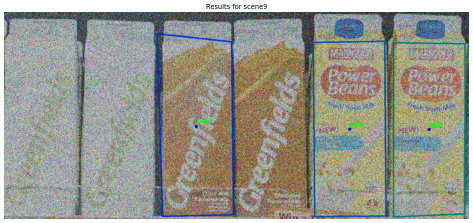


Results for scene9:
Product ref19 - 1 instance(s) found:
  Instance 1 {position: (615, 366), width: 243px, height: 584px}
Product ref20 - 2 instance(s) found:
  Instance 1 {position: (1106, 374), width: 233px, height: 560px}
  Instance 2 {position: (1360, 375), width: 228px, height: 557px}


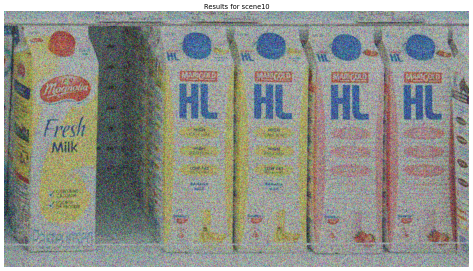


Results for scene10:


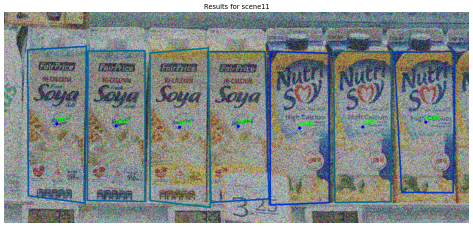


Results for scene11:
Product ref17 - 4 instance(s) found:
  Instance 1 {position: (168, 358), width: 186px, height: 497px}
  Instance 2 {position: (357, 365), width: 184px, height: 479px}
  Instance 3 {position: (746, 366), width: 194px, height: 479px}
  Instance 4 {position: (559, 369), width: 192px, height: 507px}
Product ref25 - 3 instance(s) found:
  Instance 1 {position: (942, 372), width: 187px, height: 487px}
  Instance 2 {position: (1344, 353), width: 193px, height: 448px}
  Instance 3 {position: (1143, 368), width: 185px, height: 479px}


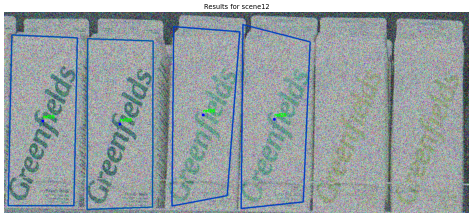


Results for scene12:
Product ref26 - 4 instance(s) found:
  Instance 1 {position: (405, 394), width: 230px, height: 594px}
  Instance 2 {position: (135, 383), width: 242px, height: 595px}
  Instance 3 {position: (945, 377), width: 241px, height: 640px}
  Instance 4 {position: (696, 362), width: 237px, height: 624px}


In [10]:
dataset_path = "./dataset/Track B"
results = detect_products(dataset_path + "/models", dataset_path + "/scenes")
plot_results(results, dataset_path + "/scenes")